In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-rna-3d-folding/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.csv
/kaggle/input/stanford-rna-3d-folding/MSA/R1108.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/8EVR_EC.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/1ZDI_S.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/5FJ1_H.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2NBY_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/3DEG_J.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2M21_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/8U3M_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2OM7_F.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/1ZC8_G.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/6WW6_C.MSA.fast

In [14]:
!pip install torch_geometric

In [15]:
import torch
import polars as pl
from torch.utils.data import DataLoader, Dataset
import torch_geometric
from torch_geometric.data import Data, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Upload the data

In [16]:
def load_data(source) -> pl.DataFrame:
    return pl.read_csv(source = source, truncate_ragged_lines = True)

In [17]:
#Load the data
train_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv")
train_labels = load_data(source = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv")
test_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")
valid_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv")
valid_labels = load_data(source = "/kaggle/input/stanford-rna-3d-folding/validation_labels.csv")
sample_submission = load_data(source = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv")

#Check for N/A
datasets = {
    "Train Sequences": train_sequences,
    "Train Labels": train_labels,
    "Test Sequences": test_sequences,
    "Validation Sequences": valid_sequences,
    "Validation Labels": valid_labels,
}

for name, df in datasets.items():
    null_counts = df.null_count().sum()
    print(f"N/A count for {name}: {null_counts}")

N/A count for Train Sequences: shape: (1, 5)
┌───────────┬──────────┬─────────────────┬─────────────┬───────────────┐
│ target_id ┆ sequence ┆ temporal_cutoff ┆ description ┆ all_sequences │
│ ---       ┆ ---      ┆ ---             ┆ ---         ┆ ---           │
│ u32       ┆ u32      ┆ u32             ┆ u32         ┆ u32           │
╞═══════════╪══════════╪═════════════════╪═════════════╪═══════════════╡
│ 0         ┆ 0        ┆ 0               ┆ 0           ┆ 5             │
└───────────┴──────────┴─────────────────┴─────────────┴───────────────┘
N/A count for Train Labels: shape: (1, 6)
┌─────┬─────────┬───────┬──────┬──────┬──────┐
│ ID  ┆ resname ┆ resid ┆ x_1  ┆ y_1  ┆ z_1  │
│ --- ┆ ---     ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ u32 ┆ u32     ┆ u32   ┆ u32  ┆ u32  ┆ u32  │
╞═════╪═════════╪═══════╪══════╪══════╪══════╡
│ 0   ┆ 0       ┆ 0     ┆ 6145 ┆ 6145 ┆ 6145 │
└─────┴─────────┴───────┴──────┴──────┴──────┘
N/A count for Test Sequences: shape: (1, 5)
┌───────────┬──────────┬─────

In [18]:
#Fill the N/A with 0 
train_sequences = train_sequences.drop_nulls()
train_labels = train_labels.drop_nulls()
print(train_sequences)
print(train_labels)

shape: (839, 5)
┌───────────┬──────────────────────┬─────────────────┬──────────────────────┬──────────────────────┐
│ target_id ┆ sequence             ┆ temporal_cutoff ┆ description          ┆ all_sequences        │
│ ---       ┆ ---                  ┆ ---             ┆ ---                  ┆ ---                  │
│ str       ┆ str                  ┆ str             ┆ str                  ┆ str                  │
╞═══════════╪══════════════════════╪═════════════════╪══════════════════════╪══════════════════════╡
│ 1SCL_A    ┆ GGGUGCUCAGUACGAGAGGA ┆ 1995-01-26      ┆ THE SARCIN-RICIN     ┆ >1SCL_1|Chain A|RNA  │
│           ┆ ACCGCACCC            ┆                 ┆ LOOP, A MODUL…       ┆ SARCIN-RIC…          │
│ 1RNK_A    ┆ GGCGCAGUGGGCUAGCGCCA ┆ 1995-02-27      ┆ THE STRUCTURE OF AN  ┆ >1RNK_1|Chain A|RNA  │
│           ┆ CUCAAAAGGC…          ┆                 ┆ RNA PSEUDO…          ┆ PSEUDOKNOT…          │
│ 1RHT_A    ┆ GGGACUGACGAUCACGCAGU ┆ 1995-06-03      ┆ 24-MER RNA HAIRPIN  

In [19]:
#Verifying the shape
print(f'The shapes of train data, train targets, test data are \n {train_sequences.shape}, {train_labels.shape}, {test_sequences.shape}')

The shapes of train data, train targets, test data are 
 (839, 5), (130950, 6), (12, 5)


In [20]:
train_sequences = train_sequences.drop(["temporal_cutoff", "description", "all_sequences"])
test_sequences = test_sequences.drop(["description", "all_sequences"])

## Visualize

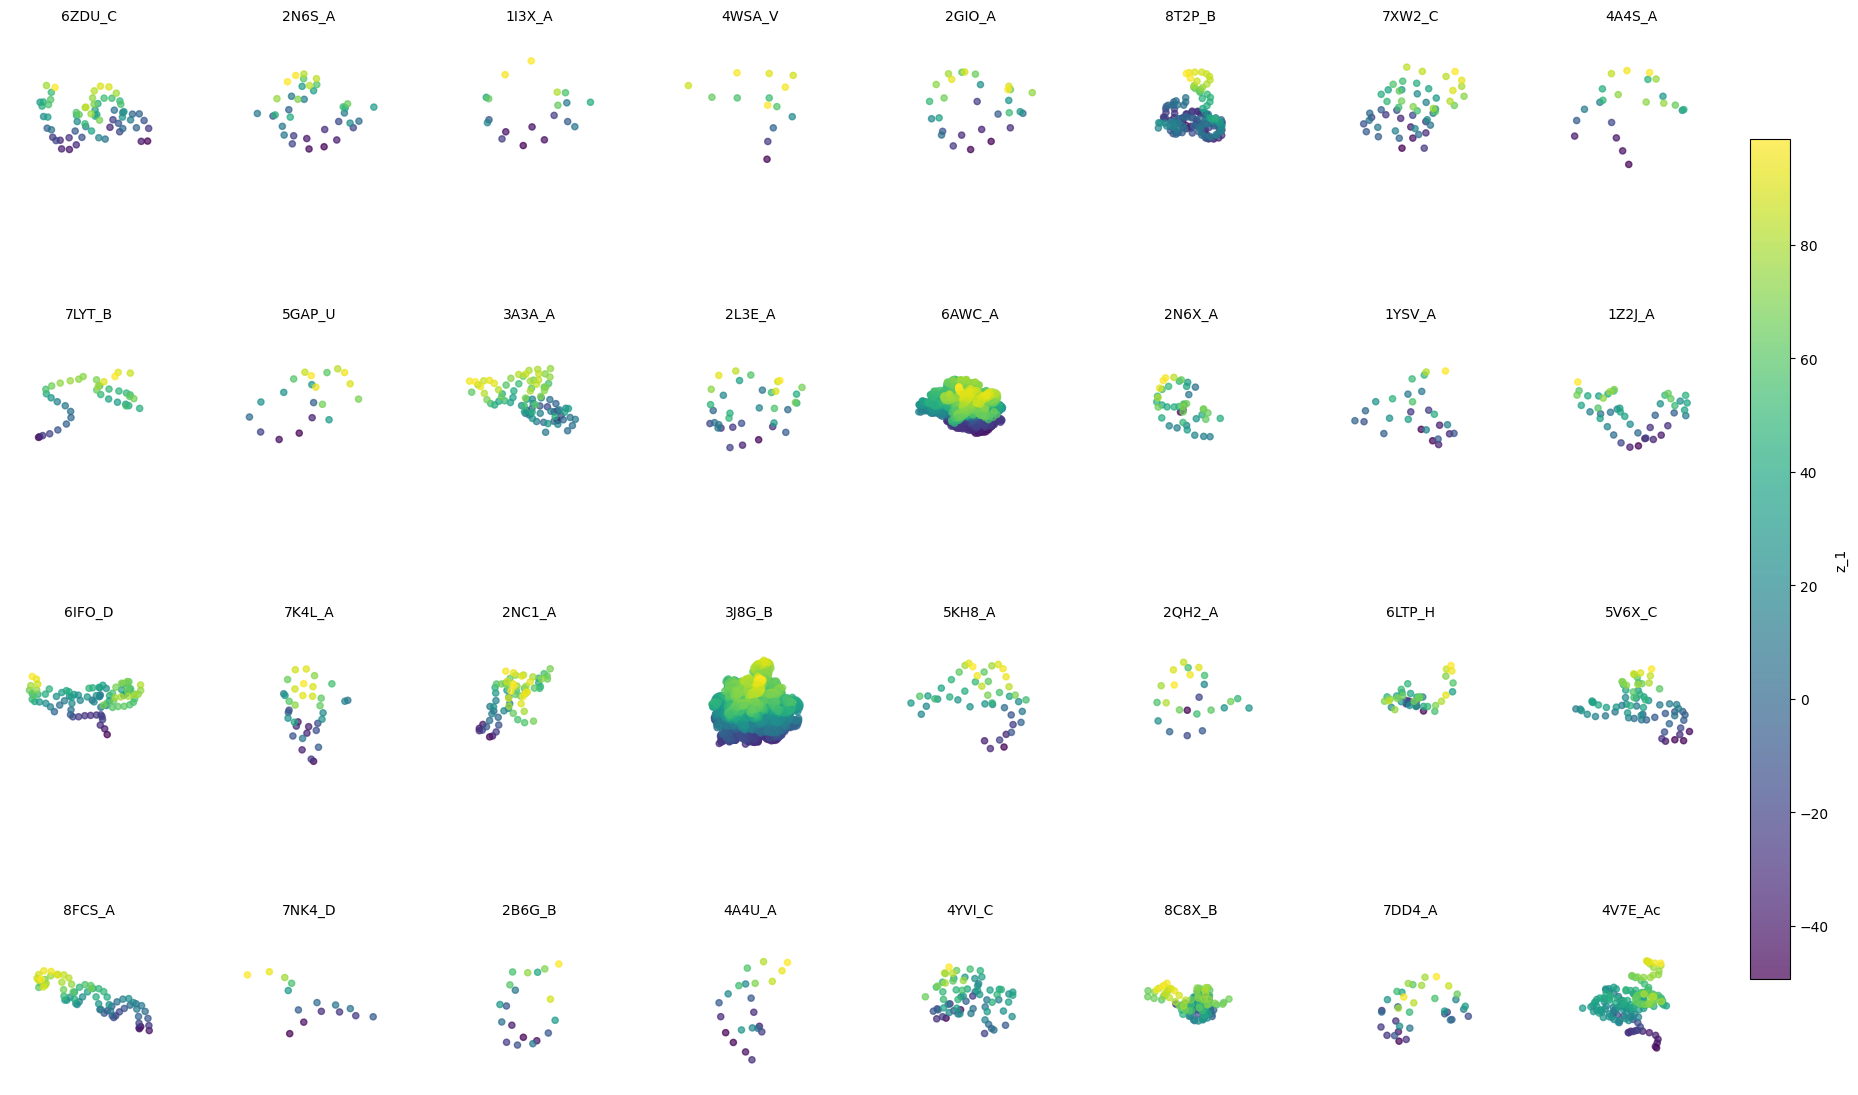

In [21]:
np.random.seed(42)

#Get unique target IDs
unique_target_ids = train_sequences['target_id'].unique().to_list()

#Randomly select 32 target IDs
idx = np.random.choice(len(unique_target_ids), size=32, replace=False)
selected_target_ids = [unique_target_ids[i] for i in idx]

#Create a figure with 4x8 subplots for 3D scatter plots
fig, axes = plt.subplots(4, 8, figsize=(20, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

#Visualize sample data in 3D scatter plots
for i, target_id in enumerate(selected_target_ids):
    axes[i].axis('off')  #Hide axis ticks
    
    #Get all labels corresponding to the current target_id
    filtered_data = train_labels.filter(pl.col('ID').str.starts_with(target_id)).sort('resid').to_dict(as_series=False)
    
    #Extract coordinates and residue names
    x = np.array(filtered_data['x_1'], dtype=float)
    y = np.array(filtered_data['y_1'], dtype=float)
    z = np.array(filtered_data['z_1'], dtype=float)
    
    #Create 3D scatter plot
    sc = axes[i].scatter(x, y, z, c=z, cmap='viridis', alpha=0.7)
    
    #Set view angle
    axes[i].view_init(elev=30, azim=45)
    
    #Set title
    axes[i].set_title(f'{target_id}', color='black', fontsize=10, pad=10)

#Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
fig.colorbar(sc, cax=cbar_ax, label='z_1', orientation='vertical')

#Adjust layout
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

#Show the plot
plt.show()

## Graph neural network and Diffusion model

****1. Preprocessing: Convert squence to graph****

In [22]:
nucleotide_map ={"A": [1, 0, 0, 0],
                 "U": [0, 1, 0, 0],
                 "G": [0, 0, 1, 0],
                 "C": [0, 0, 0, 1]}

# One-hot encoding of nucleotides
def sequence_to_graph(rna_sequence: str) -> Data:
    node_features = torch.tensor([nucleotide_map.get(nuc, [0, 0, 0, 0]) for nuc in rna_sequence], dtype = torch.float)
    edge_index = torch.tensor([[i, i + 1] for i in range(len(rna_sequence) - 1)], dtype = torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim = 1)
    return Data(x = node_features, edge_index = edge_index)

print(sequence_to_graph(rna_sequence = train_sequences[0,1]))

Data(x=[29, 4], edge_index=[2, 56])


**2. Create a Data Loader**

In [23]:
# RNA_Graph_Dataset
class RNA_Graph_Dataset(Dataset):
    def __init__(self, train_sequences: pl.DataFrame, train_labels: pl.DataFrame):
        self.train_sequences = train_sequences

        # Create target_id column from ID (e.g., "1SCL_A_1" → "1SCL_A")
        self.train_labels = train_labels.with_columns([
            (pl.col("ID").str.split("_").list.get(0) + "_" + pl.col("ID").str.split("_").list.get(1)).alias("target_id")
        ])

        # Only keep sequences with matching labels
        valid_ids = self.train_labels.select("target_id").unique().get_column("target_id")
        self.train_sequences = self.train_sequences.filter(
            pl.col("target_id").is_in(valid_ids)
        )

        # Preload rows for fast access
        self.seq_rows = self.train_sequences.rows(named=True)

    def __len__(self):
        return len(self.seq_rows)

    def __getitem__(self, idx):
        row = self.seq_rows[idx]
        target_id = row["target_id"]
        sequence = row["sequence"]

        graph = sequence_to_graph(sequence)

        # Get corresponding coordinates
        label_rows = self.train_labels.filter(pl.col("target_id") == target_id).sort("resid")
        coords = torch.tensor(label_rows.select(["x_1", "y_1", "z_1"]).to_numpy(), dtype=torch.float)

        assert coords.shape[0] == graph.x.shape[0], f"Mismatch in length for {target_id}"
        graph.y = coords
        graph.target_id = target_id  # Add ID for traceability
        return graph

In [25]:
dataset = RNA_Graph_Dataset(train_sequences, train_labels)

# Print the first sample
sample = dataset[0]
print(sample)
print(sample.x.shape)        # Node features
print(sample.y.shape)        # 3D coordinates
print(sample.edge_index)     # Graph edges
print(sample.target_id)      # String ID

Data(x=[29, 4], edge_index=[2, 56], y=[29, 3], target_id='1SCL_A')
torch.Size([29, 4])
torch.Size([29, 3])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  1,  2,  3,  4,  5,  6,  7,  8,
          9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
         27, 28],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27]])
1SCL_A


**Model Achitecture**

We will use GNN to generate node embeddings and use SE(3)-Transformers to iteratively refine/predict 3d positions